In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0


In [29]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

In [31]:
Xp = X.filter(regex = 'card_color').copy()
Xp['home_fouls'] = X.filter(regex = 'home_team_foul').sum(axis = 1)
Xp['away_fouls'] = X.filter(regex = 'away_team_foul').sum(axis = 1)

In [49]:
np.random.seed(10)
scaler = StandardScaler().fit(Xp)
X_s = scaler.transform(Xp)

size = np.min(np.unique(y[y != 'D'], return_counts = True)[1])
W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
#D = np.random.choice(np.arange(y.shape[0])[y == 'D'], size = size)
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

idx = [W, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)

In [50]:
weights

{'W': 1.0, 'L': 2.061224489795918}

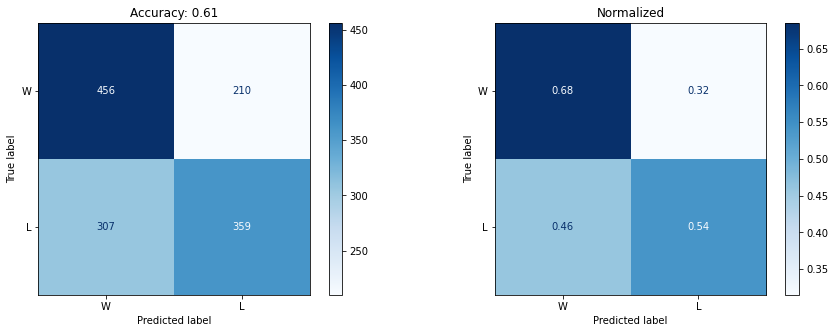

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.684685   0.597641  0.684685  0.638209      666
1      L  0.539039   0.630931  0.539039  0.581377      666
2  Total  0.611862   0.614286  0.611862  0.609793     1332


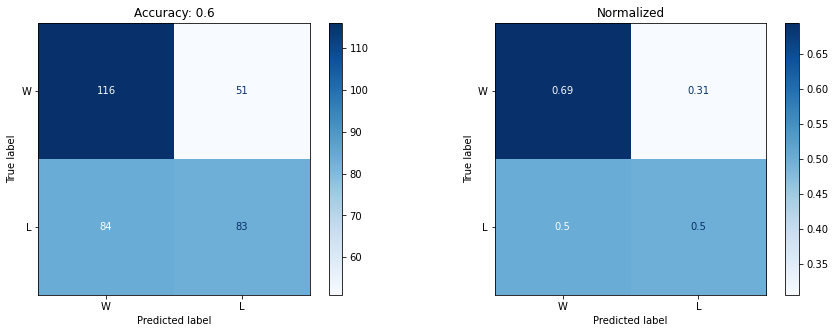

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.694611   0.580000  0.694611  0.632153      167
1      L  0.497006   0.619403  0.497006  0.551495      167
2  Total  0.595808   0.599701  0.595808  0.591824      334


In [55]:
params = {
    #'class_weight': weights,
    'multi_class' : 'multinomial'
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train, labels = ['W', 'L']))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'L']))

In [65]:
pd.DataFrame({"feature" : Xp.columns,"importance":np.e**clf.coef_[0]}).sort_values(by = 'importance', ascending = False)

,feature,importance
3,away_team_card_color_y2,1.057055
5,away_team_card_color_r,1.051260
6,home_fouls,0.995879
7,away_fouls,0.986425
4,home_team_card_color_r,0.930341
2,home_team_card_color_y2,0.926968
1,away_team_card_color_y,0.925517
0,home_team_card_color_y,0.808338


### With elo

In [94]:
X = data[data.columns[9:]].drop(['result'],axis = 1)
y = data['result']
Xp = X.filter(regex = 'card_color|elo').copy()
Xp['home_fouls'] = X.filter(regex = 'home_team_foul').sum(axis = 1)
Xp['away_fouls'] = X.filter(regex = 'away_team_foul').sum(axis = 1)

In [95]:
Xp = Xp.iloc[30:].reset_index(drop = True)
y = y.iloc[30:].reset_index(drop = True)

In [103]:
np.random.seed(10)
scaler = StandardScaler().fit(Xp)
X_s = scaler.transform(Xp)

size = np.min(np.unique(y[y != 'D'], return_counts = True)[1])
W = np.random.choice(y.index[y == 'W'], size = size)
#D = np.random.choice(y.index[y == 'D'], size = size)
L = np.random.choice(y.index[y == 'L'], size = size)

idx = [W, D, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)

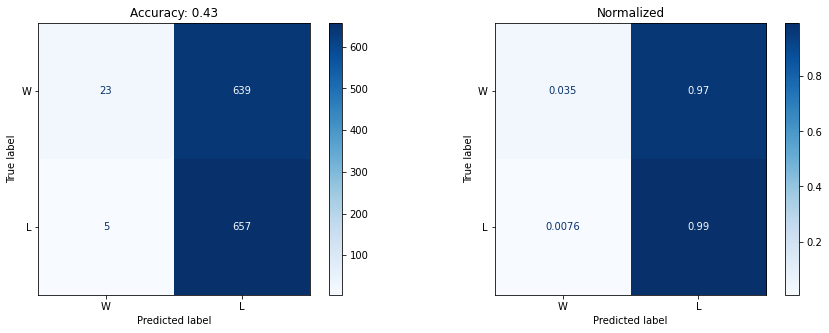

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.034743   0.793103  0.034743  0.066570      662
1      L  0.992447   0.423871  0.992447  0.594033      662
2  Total  0.430652   0.608487  0.513595  0.330301     1324


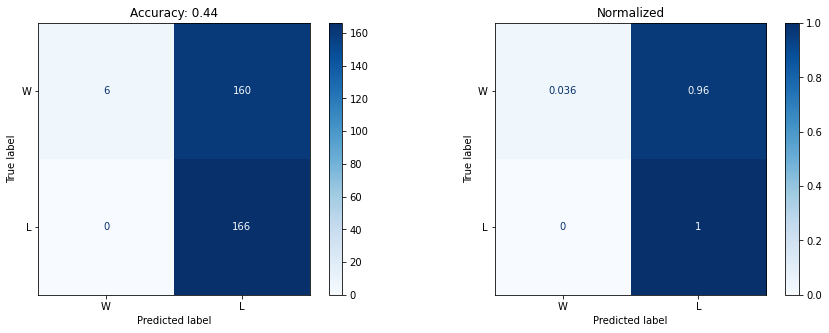

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.036145   1.000000  0.036145  0.069767      166
1      L  1.000000   0.426735  1.000000  0.598198      166
2  Total  0.435443   0.713368  0.518072  0.333983      332


In [105]:
params = {
    #'class_weight': weights,
    'multi_class' : 'multinomial'
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train, labels = ['W', 'L']))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'L']))

In [106]:
clf2 = RandomForestClassifier().fit(X_train, y_train)

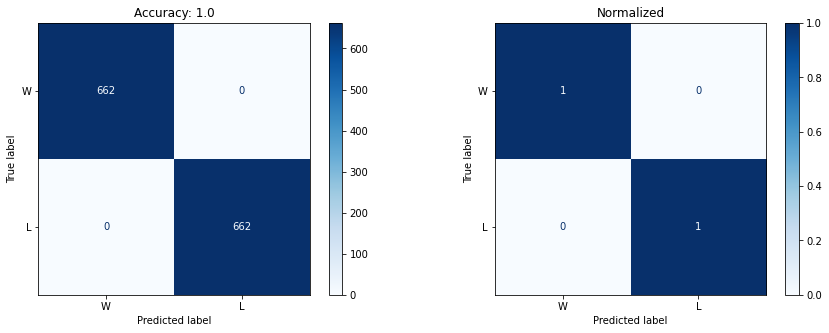

   Class  Accuracy  Precision  Recall   F1  Support
0      W       1.0        1.0     1.0  1.0      662
1      L       1.0        1.0     1.0  1.0      662
2  Total       1.0        1.0     1.0  1.0     1324


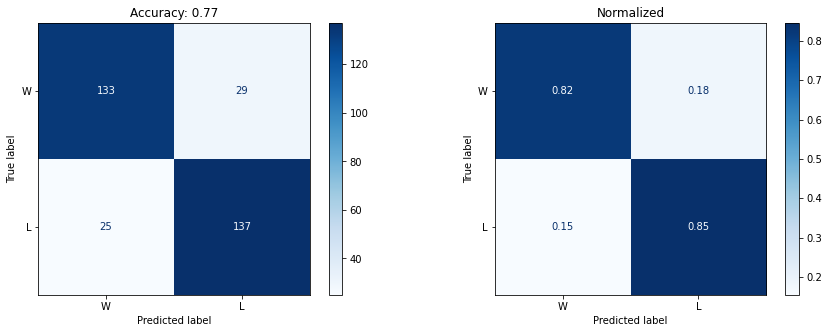

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.801205   0.773256  0.801205  0.786982      166
1      L  0.825301   0.761111  0.825301  0.791908      166
2  Total  0.772152   0.767183  0.813253  0.789445      332


In [107]:
print(metric_suite(clf2, X_train, y_train, labels = ['W', 'L']))
print(metric_suite(clf2, X_test, y_test, labels = ['W', 'L']))

In [110]:
from sklearn.inspection import permutation_importance

In [128]:
clf2.score(X_test, y_test)

0.7721518987341772

In [211]:
import pickle
pickle.dump(clf2, open("rf_baseline_elo.sav", 'wb'))

In [117]:
r = permutation_importance(clf2, X_test, y_test, n_repeats = 30, random_state = 0)

In [135]:
qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = Xp.columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

home_elo		0.186 +/- 0.019
away_elo		0.16 +/- 0.02
home_team_card_color_y		0.121 +/- 0.012
home_fouls		0.068 +/- 0.009
away_fouls		0.066 +/- 0.013
away_team_card_color_y		0.038 +/- 0.008
away_team_card_color_r		0.012 +/- 0.004


In [136]:
# Above is average decrease in accuracy score when feature is shuffled

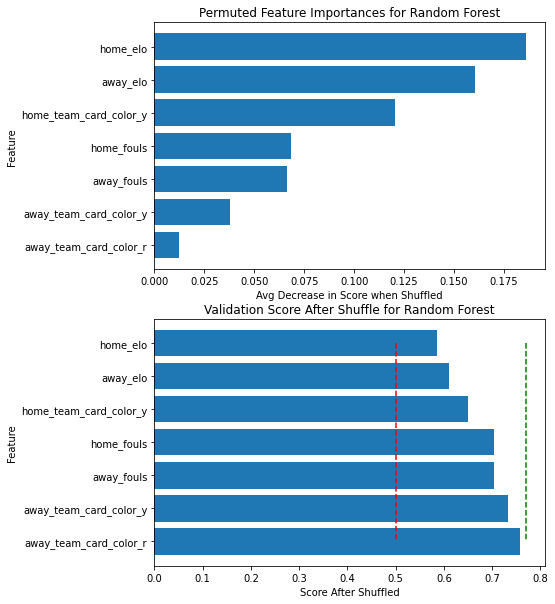

In [154]:
fig, axs = plt.subplots(2,1, figsize = (7,10))
axs[0].barh(Xp.columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1])
axs[0].set_title('Permuted Feature Importances for Random Forest')
axs[0].set_xlabel('Avg Decrease in Score when Shuffled')
axs[0].set_ylabel('Feature')

axs[1].barh(Xp.columns[qual_idx][::-1], 0.771151-r.importances_mean[qual_idx][::-1])
axs[1].set_title('Validation Score After Shuffle for Random Forest')
axs[1].set_xlabel('Score After Shuffled')
axs[1].set_ylabel('Feature')

axs[1].plot([0.5, 0.5], [Xp.columns[qual_idx][0], Xp.columns[qual_idx][-1]], 'r--')
axs[1].plot([0.771151, 0.771151], [Xp.columns[qual_idx][0], Xp.columns[qual_idx][-1]], 'g--')
plt.show()

In [129]:
from sklearn.preprocessing import PolynomialFeatures

In [188]:
grid = {
    'max_depth' : [10, 20, 30, 50, None],
    'min_samples_split' : [2, 5, 10, 20],
    'min_samples_leaf' : [1, 2, 5, 10, 20],
    'n_jobs' : [-1]
}
clf3 = GridSearchCV(RandomForestClassifier(), grid, cv = 3, verbose = 3).fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_jobs=-1;, score=0.676 total time=   0.1s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_jobs=-1;, score=0.644 total time=   0.1s
[CV 3/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_jobs=-1;, score=0.627 total time=   0.1s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_jobs=-1;, score=0.649 total time=   0.1s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_jobs=-1;, score=0.624 total time=   0.1s
[CV 3/3] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_jobs=-1;, score=0.589 total time=   0.1s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_jobs=-1;, score=0.624 total time=   0.1s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_jobs=-1;, score=0.612 total time=   0.1s
[CV 3/3] END max_depth=10, min_samples_leaf=1, 

[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_jobs=-1;, score=0.653 total time=   0.1s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_jobs=-1;, score=0.631 total time=   0.1s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_jobs=-1;, score=0.643 total time=   0.1s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_jobs=-1;, score=0.643 total time=   0.1s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_jobs=-1;, score=0.608 total time=   0.1s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_jobs=-1;, score=0.606 total time=   0.1s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_jobs=-1;, score=0.617 total time=   0.1s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_jobs=-1;, score=0.599 total time=   0.1s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_jobs=-1;, score=0.580 total time=   

[CV 3/3] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_jobs=-1;, score=0.601 total time=   0.1s
[CV 1/3] END max_depth=30, min_samples_leaf=5, min_samples_split=10, n_jobs=-1;, score=0.603 total time=   0.1s
[CV 2/3] END max_depth=30, min_samples_leaf=5, min_samples_split=10, n_jobs=-1;, score=0.587 total time=   0.1s
[CV 3/3] END max_depth=30, min_samples_leaf=5, min_samples_split=10, n_jobs=-1;, score=0.586 total time=   0.1s
[CV 1/3] END max_depth=30, min_samples_leaf=5, min_samples_split=20, n_jobs=-1;, score=0.577 total time=   0.1s
[CV 2/3] END max_depth=30, min_samples_leaf=5, min_samples_split=20, n_jobs=-1;, score=0.584 total time=   0.1s
[CV 3/3] END max_depth=30, min_samples_leaf=5, min_samples_split=20, n_jobs=-1;, score=0.582 total time=   0.1s
[CV 1/3] END max_depth=30, min_samples_leaf=10, min_samples_split=2, n_jobs=-1;, score=0.583 total time=   0.1s
[CV 2/3] END max_depth=30, min_samples_leaf=10, min_samples_split=2, n_jobs=-1;, score=0.591 total time= 

[CV 2/3] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_jobs=-1;, score=0.591 total time=   0.1s
[CV 3/3] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_jobs=-1;, score=0.572 total time=   0.1s
[CV 1/3] END max_depth=50, min_samples_leaf=10, min_samples_split=20, n_jobs=-1;, score=0.573 total time=   0.1s
[CV 2/3] END max_depth=50, min_samples_leaf=10, min_samples_split=20, n_jobs=-1;, score=0.582 total time=   0.1s
[CV 3/3] END max_depth=50, min_samples_leaf=10, min_samples_split=20, n_jobs=-1;, score=0.578 total time=   0.1s
[CV 1/3] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_jobs=-1;, score=0.556 total time=   0.1s
[CV 2/3] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_jobs=-1;, score=0.574 total time=   0.1s
[CV 3/3] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_jobs=-1;, score=0.551 total time=   0.1s
[CV 1/3] END max_depth=50, min_samples_leaf=20, min_samples_split=5, n_jobs=-1;, score=0.564 total 

[CV 2/3] END max_depth=None, min_samples_leaf=20, min_samples_split=20, n_jobs=-1;, score=0.576 total time=   0.1s
[CV 3/3] END max_depth=None, min_samples_leaf=20, min_samples_split=20, n_jobs=-1;, score=0.551 total time=   0.1s


In [218]:
pd.DataFrame(clf3.cv_results_).filter(regex = 'param_')

,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_jobs
0,10,1,2,-1
1,10,1,5,-1
2,10,1,10,-1
3,10,1,20,-1
4,10,2,2,-1
...,...,...,...,...
95,None,10,20,-1
96,None,20,2,-1
97,None,20,5,-1
98,None,20,10,-1


In [226]:
cv = pd.DataFrame(clf3.cv_results_)

In [234]:
cv[['param_min_samples_split', 'mean_test_score']].groupby(by = 'param_min_samples_split').mean()

,mean_test_score
param_min_samples_split,
2,0.610380
5,0.605111
10,0.595967
20,0.582290


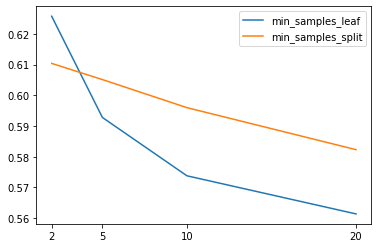

In [237]:
plt.plot(cv[['param_min_samples_leaf', 'mean_test_score']].groupby(by = 'param_min_samples_leaf').mean().iloc[1:])
plt.plot(cv[['param_min_samples_split', 'mean_test_score']].groupby(by = 'param_min_samples_split').mean())
plt.xlabel('')
plt.xticks([2, 5, 10, 20])
plt.legend(labels = ['min_samples_leaf', 'min_samples_split'])
plt.show()

In [242]:
val_acc = [RandomForestClassifier(**param).fit(X_train, y_train).score(X_test, y_test) for param in tqdm(cv['params'])]

  0%|          | 0/100 [00:00<?, ?it/s]

In [248]:
cv[['param_max_depth', 'mean_test_score']].fillna(100).groupby(by = 'param_max_depth').mean()

,mean_test_score
param_max_depth,
10,0.590433
20,0.600914
30,0.600439
50,0.601230
100,0.599171


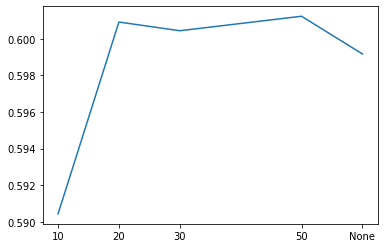

In [254]:
plt.plot(cv[['param_max_depth', 'mean_test_score']].fillna(60).groupby(by = 'param_max_depth').mean())
plt.xticks([10, 20, 30, 50, 60], ['10', '20', '30', '50', 'None'])
plt.show()

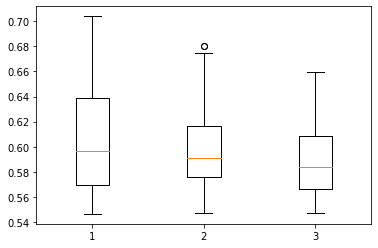

In [189]:
plt.boxplot(pd.DataFrame(clf3.cv_results_).filter(regex = 'test_score').iloc[:, :3])
plt.show()

In [190]:
clf3.best_params_

{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_jobs': -1}

In [258]:
Xp.columns

Index(['home_team_card_color_y', 'away_team_card_color_y',
       'home_team_card_color_y2', 'away_team_card_color_y2',
       'home_team_card_color_r', 'away_team_card_color_r', 'home_elo',
       'away_elo', 'home_fouls', 'away_fouls'],
      dtype='object')

In [191]:
clf4 = RandomForestClassifier(**clf3.best_params_).fit(X_train, y_train)
clf4.score(X_test, y_test)

0.769620253164557

In [201]:
np.random.seed(10)
scaler = StandardScaler().fit(Xp)

poly = PolynomialFeatures(degree = 2, interaction_only=True, include_bias = False)
X_s = poly.fit_transform(Xp)
X_s = StandardScaler().fit_transform(X_s)

size = np.min(np.unique(y[y != 'D'], return_counts = True)[1])
W = np.random.choice(y.index[y == 'W'], size = size)
L = np.random.choice(y.index[y == 'L'], size = size)

idx = [W, D, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)

In [202]:
clf5 = RandomForestClassifier().fit(X_train_, y_train_)

In [203]:
print(clf5.score(X_train_, y_train_))
print(clf5.score(X_test_, y_test_))

1.0
0.7544303797468355


In [204]:
r2 = permutation_importance(clf5, X_test_, y_test_, n_repeats = 30, random_state = 0)

In [210]:
qual_idx = []
for i in r2.importances_mean.argsort()[::-1]:
    #if r2.importances_mean[i] - 2* r2.importances_std[i] > 0:
    qual_idx += [i]
    print("{feat}\t\t{mean} +/- {std}".format(
        feat =poly.get_feature_names_out()[i],
        mean = np.round(r2.importances_mean[i], 3),
        std = np.round(r2.importances_std[i], 3)
    ))

home_elo		0.053 +/- 0.011
away_elo		0.008 +/- 0.009
home_fouls		0.007 +/- 0.004
home_elo away_elo		0.003 +/- 0.006
away_team_card_color_y away_elo		0.001 +/- 0.007
away_team_card_color_y2 home_fouls		0.0 +/- 0.001
home_team_card_color_r away_elo		0.0 +/- 0.001
home_team_card_color_r		0.0 +/- 0.001
away_team_card_color_r away_fouls		0.0 +/- 0.001
away_team_card_color_y2 away_elo		0.0 +/- 0.001
away_team_card_color_y away_team_card_color_y2		0.0 +/- 0.001
home_team_card_color_y2 away_team_card_color_y2		0.0 +/- 0.0
away_team_card_color_y2		0.0 +/- 0.0
home_team_card_color_y2 home_team_card_color_r		0.0 +/- 0.0
home_team_card_color_y2 away_team_card_color_r		0.0 +/- 0.0
home_team_card_color_y2		0.0 +/- 0.0
home_team_card_color_y2 home_fouls		0.0 +/- 0.0
home_team_card_color_y away_team_card_color_y2		0.0 +/- 0.0
away_team_card_color_y2 home_team_card_color_r		0.0 +/- 0.0
away_team_card_color_y2 away_team_card_color_r		0.0 +/- 0.0
away_team_card_color_y2 home_elo		0.0 +/- 0.001
away_team_c